In [66]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import os
import json
import urllib2
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

#### Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z Either obtain the data through the API or download the csv file, and move it to PUIDATA

In [67]:
os.getenv('PUI2016')
os.getenv('PUIDATA')

'/home/cusp/cx495/PUIdata'

In [68]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA")+ "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

In [69]:
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [70]:
nrg.head()

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64fc0f3c10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f64d6f29b50>]], dtype=object)

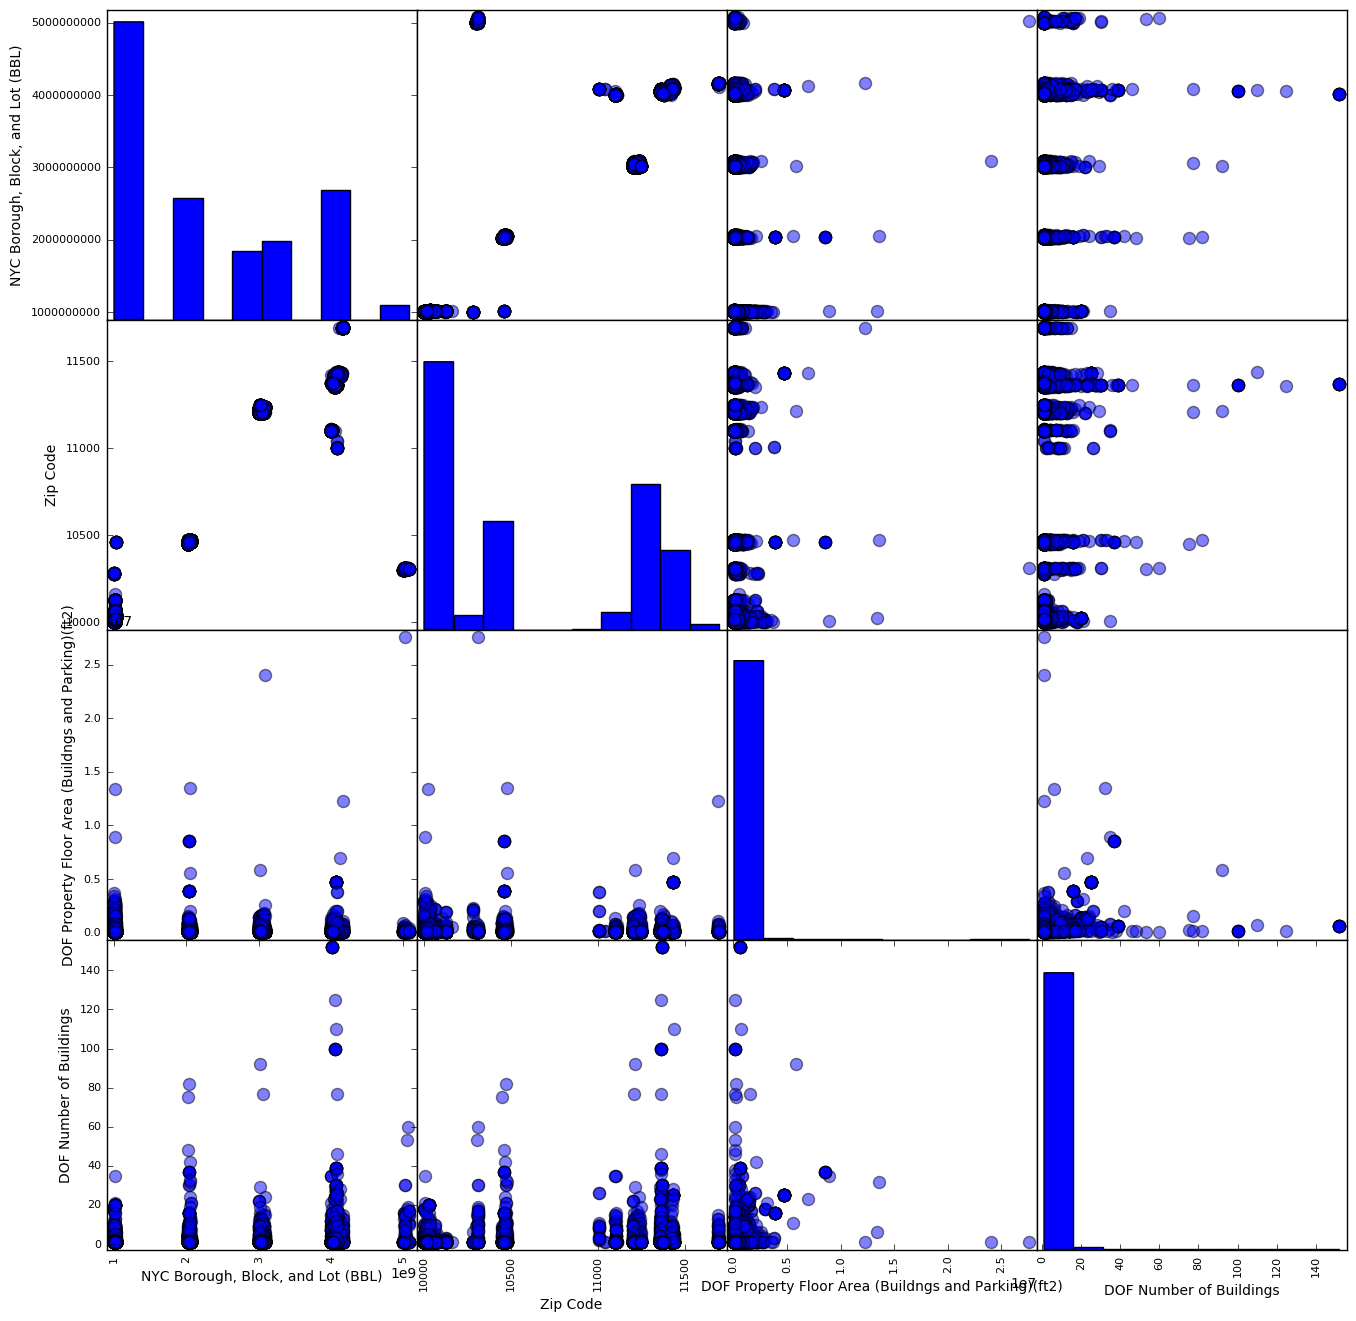

In [71]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), alpha = 0.5)

### Figure 1: scatter matrix of all numerical values in the files.

In [82]:
# prepare your BBL columns
nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL'}, inplace = True)

In [83]:
nrg.head()

,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,TotalEnergy
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,918919,NaN,NaN,NaN,NaN
14354,4.021460e+09,NaN,NaN,NaN,NaN,NaN,NaN,11375.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0,NaN
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64200,NaN,NaN,NaN,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,NaN,NaN,10001.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0,NaN
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,50000,NaN,NaN,NaN,NaN


#### This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into. This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..." However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [84]:
 def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    
vcanconvert = np.vectorize(canconvert)

columns2convert = nrg.columns

cans = {i:vcanconvert(nrg[i]) for i in columns2convert} 
for i in columns2convert:
    nrg.loc[~cans[i],i] = float('NaN')

#### Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest.I can replace the entries that failed to be converted to 'NaN' (because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [85]:
##check that your conversion worked
print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     125.4
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14777      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: Site EUI(kBtu/ft2), dtype: float64


#### However this datasets does not have the number of units. We can find that in the Pluto dataset.
#### Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp

In [86]:
floc = "~/PUIdata/MNMapPLUTO.shp"
bsize = gp.GeoDataFrame.from_file("MNMapPLUTO.shp")
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [87]:
bsize.head()

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,0.000000e+00,None,720 PARK AVENUE,R10/PI/LH-1A,R8B,2,5040000.0,30591900.0,1.013850e+09,203490,...,2006,1928,None,10021,R10,R8B,None,None,8c,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,0.000000e+00,None,3 WEST 83 STREET,R8B,R10A,2,437850.0,1267200.0,1.011970e+09,13839,...,0,1900,None,10024,R8B,R10A,None,None,5d,"POLYGON ((992273.6850000024 224863.4904000014,..."


In [88]:
bsize.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42667    1.014738e+09
42668    1.006208e+09
42669    1.007218e+09
42670    1.013428e+09
42671    1.019448e+09
42672    1.017298e+09
42673    1.018488e+09
42674    1.005008e+09
42675    1.020448e+09
42676    1.004518e+09
42677    1.020958e+09
42678    1.007688e+09
42679    1.008498e+09
42680    1.017298e+09
42681    1

In [89]:
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

invalid entries changed to NaN 16170


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [90]:
nrg['TotalEnergy'] = nrg['Site EUI(kBtu/ft2)'].astype(float) * nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

nrg.dtypes

BBL                                                                float64
Co-reported BBL Status                                              object
BBLs Co-reported                                                    object
Reported NYC Building Identificaiton Numbers (BINs)                 object
Street Number                                                       object
Street Name                                                         object
Borough                                                             object
Zip Code                                                           float64
DOF Benchmarking Submission Status                                  object
Site EUI(kBtu/ft2)                                                  object
Weather Normalized Site EUI(kBtu/ft2)                               object
Source EUI(kBtu/ft2)                                                object
Weather Normalized Source EUI(kBtu/ft2)                             object
Municipally Supplied Pota

In [91]:
## merge
bblnrgdata = pd.merge(nrg, bsize, on = ['BBL'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64c70f89d0>,
        ...,
        ...,
        ...,
       ..., 
        ...,
        ...,
        ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f647e7414d0>]], dtype=object)

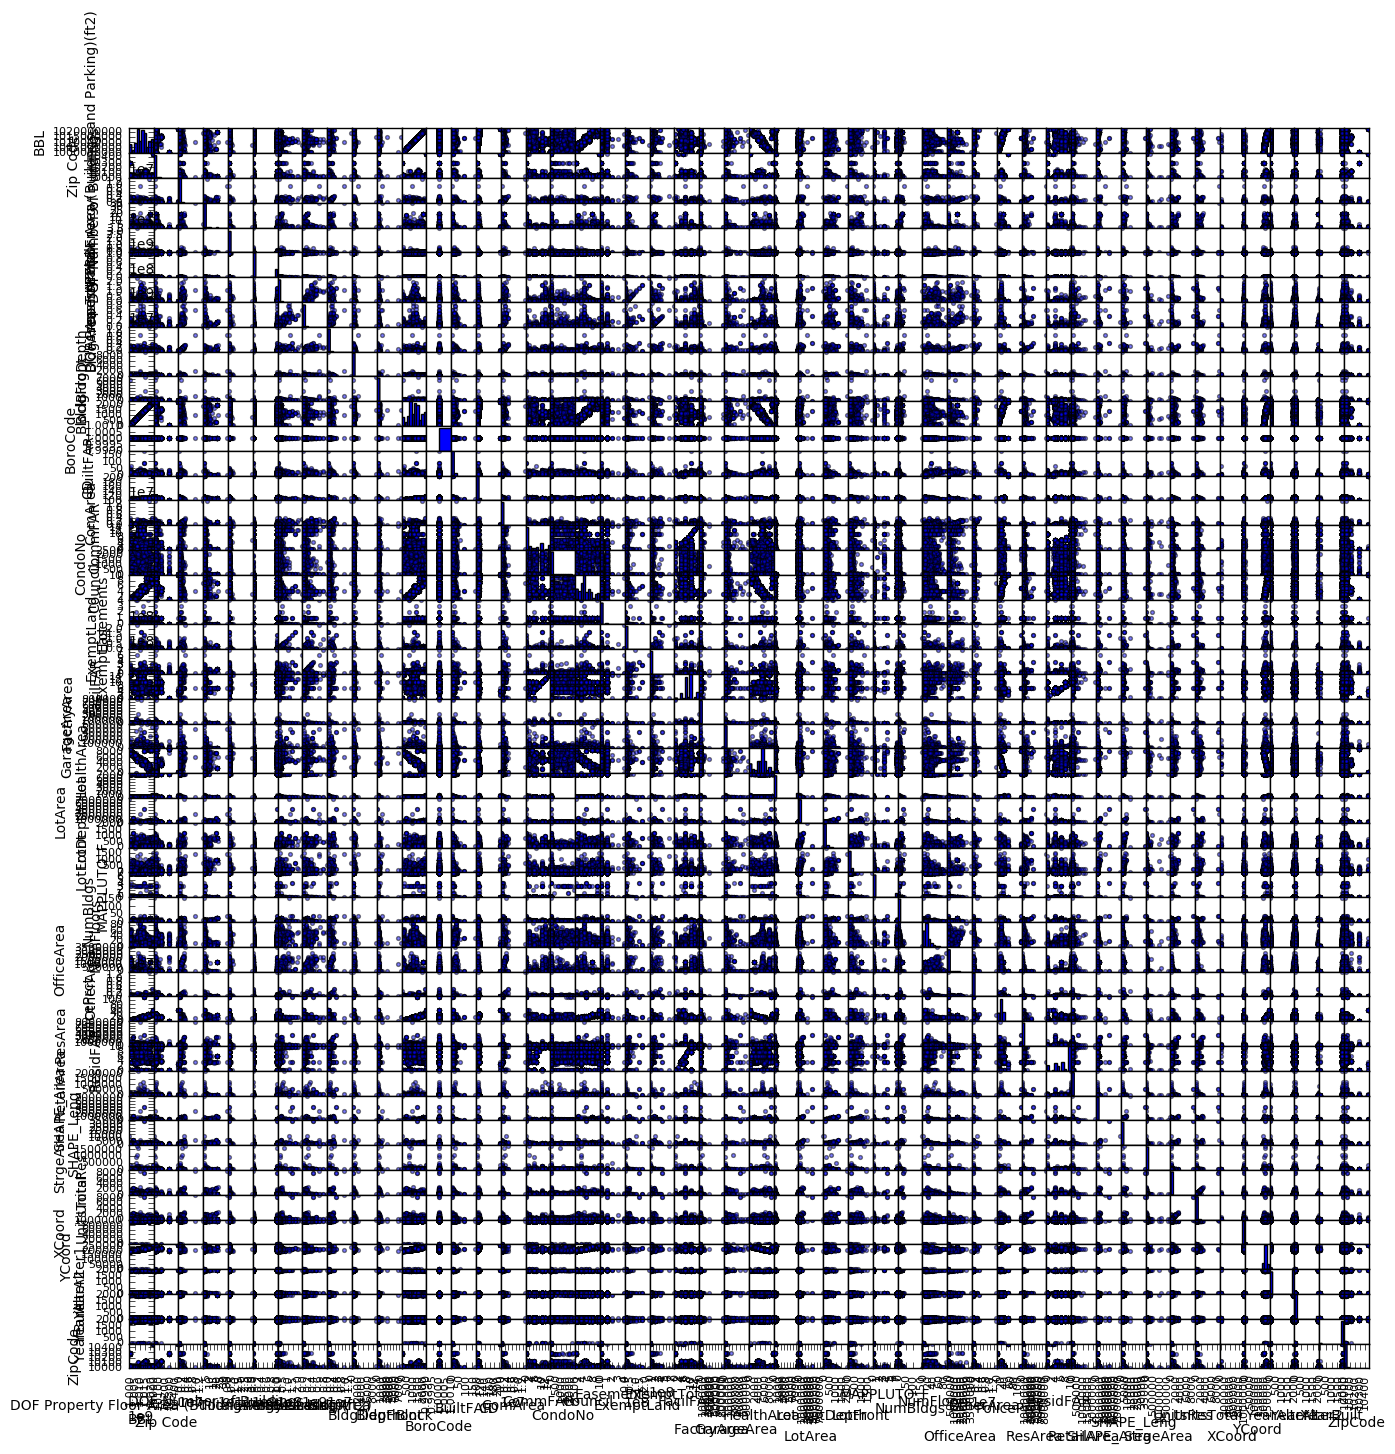

In [92]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

#### Make a scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.

(0, 1000)

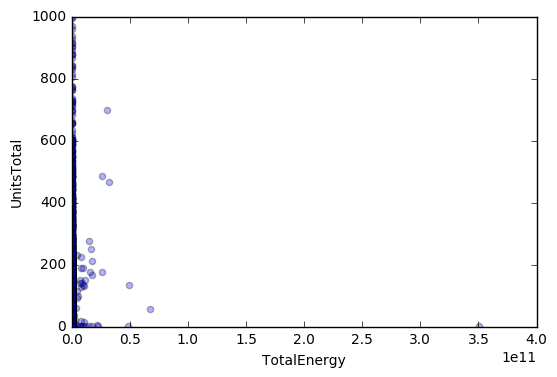

In [94]:
ax1 = bblnrgdata.plot(x = 'TotalEnergy', y = 'UnitsTotal', kind = 'scatter', alpha =0.3)
xlim(0,4e11)
ylim(0,1000)

## Figure 2:a scatter plot first of Energy vs Units

#### Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

(1, 1000)

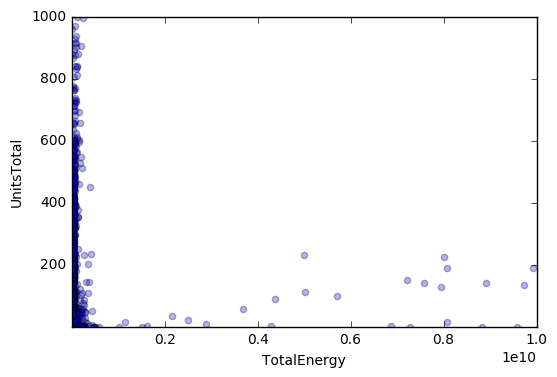

In [95]:
ax2 = bblnrgdata.plot(x = 'TotalEnergy', y = 'UnitsTotal', kind = 'scatter', alpha = 0.3)
## Adjust the xlim to zoom.
xlim(1000,1e10)
ylim(1,1000)

## Figure 3 : a zoom of Figure2

#### when the points in a plot all look scrunched against the axis.Try to make a log plot instead. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

### NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

In [96]:
# outlier removal
bblnrgdata_cut = bblnrgdata[bblnrgdata.TotalEnergy > 10000]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut.UnitsTotal > 8]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut.UnitsTotal < 1000] 

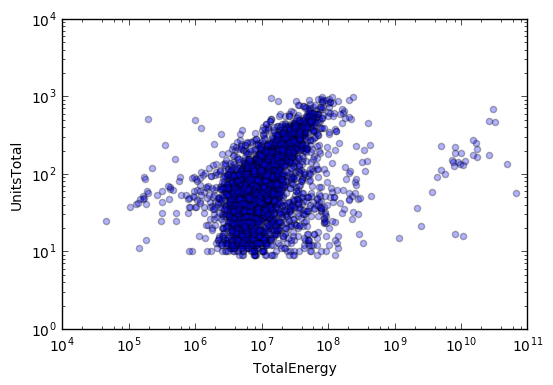

In [97]:
ax = bblnrgdata_cut.plot(x = 'TotalEnergy', y = 'UnitsTotal', kind = 'scatter', loglog = True, alpha = 0.3)

## Figure 4: a log model of Energy vs Units

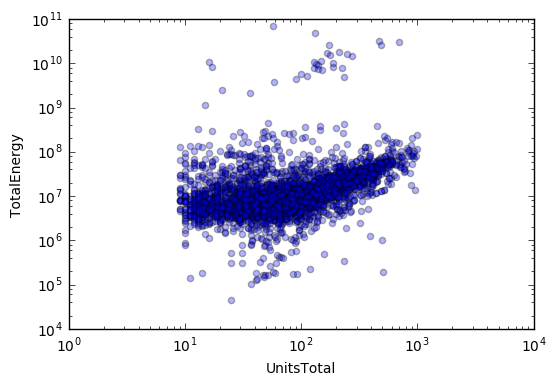

In [98]:
ax = bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'TotalEnergy', kind = 'scatter', loglog = True, alpha = 0.3)

## Figure 5: a log model of Units vs Energy


#### Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

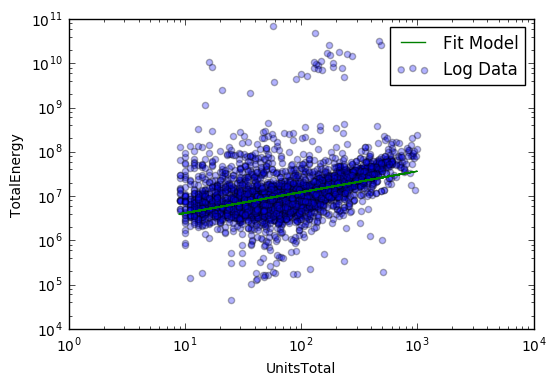

In [99]:
#fit units v.s. energy
X = sm.add_constant(np.log10(bblnrgdata_cut['UnitsTotal']))
linmodel1 = sm.OLS(np.log10(bblnrgdata_cut['TotalEnergy']), X, missing='drop').fit() 
# ignores entires 
# where x or y is NaN
    
ax = bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'TotalEnergy', kind = 'scatter', loglog = True, label = 'Log Data', alpha = 0.3)
ax.plot(bblnrgdata_cut['UnitsTotal'], 10**(linmodel1.predict()), c = 'g', label = 'Fit Model')
ax.legend()

## Figure 6: a fit line of Units vs Energy

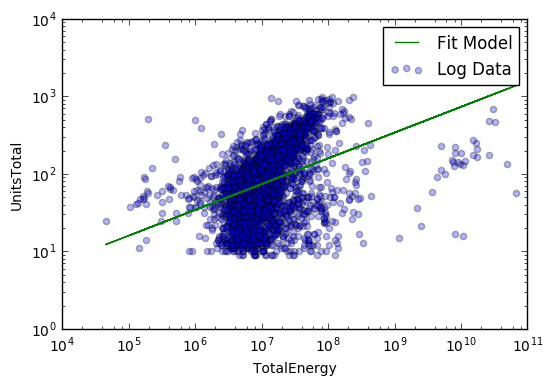

In [100]:
#fits energy v.s. units(switch)
X = sm.add_constant(np.log10(bblnrgdata_cut['TotalEnergy']))
linmodel2 = sm.OLS(np.log10(bblnrgdata_cut['UnitsTotal']), X, missing='drop').fit() 
# ignores entires 
# where x or y is NaN
    
ax = bblnrgdata_cut.plot(x = 'TotalEnergy', y = 'UnitsTotal', kind = 'scatter', loglog = True, label = 'Log Data', alpha = 0.3)
ax.plot(bblnrgdata_cut['TotalEnergy'], 10**(linmodel2.predict()), c = 'g', label = 'Fit Model')
ax.legend()

## Figure 7: a fit line of Energy vs Units

#### Evaluate which is better by calculating the chi square.

In [101]:
def chisqcalc(model, x):
    chisq = sum(model.resid**2 / np.sqrt(x))
    return(chisq)
    
print (chisqcalc(linmodel1, np.log10(bblnrgdata_cut['UnitsTotal'])))

print (chisqcalc(linmodel2, np.log10(bblnrgdata_cut['TotalEnergy'])))

linmodel1.summary()

624.096538483
216.865638669


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalEnergy   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     798.7
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          2.86e-161
Time:                        22:17:47   Log-Likelihood:                -2565.4
No. Observations:                4288   AIC:                             5135.
Df Residuals:                    4286   BIC:                             5147.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1425      0.032    190.982      0.000         6.079     6.206
UnitsTotal     0.4728      0.017     28.260      0.000         0.440     0.506
==============================================================================
Omnibus:                     2323.385   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43084.632
Skew:                           2.172   Prob(JB):                         0.00
Kurtosis:                      17.909   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### so the first model is better -units vs energy.

#### fit a 2nd degree polynomial

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log10(TotalEnergy)   R-squared:                       0.157
Model:                               OLS   Adj. R-squared:                  0.157
Method:                    Least Squares   F-statistic:                     798.7
Date:                   Wed, 19 Oct 2016   Prob (F-statistic):          2.86e-161
Time:                           22:18:54   Log-Likelihood:                -2565.4
No. Observations:                   4288   AIC:                             5135.
Df Residuals:                       4286   BIC:                             5147.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                             6.1425      0.032    190.982      0.000         6.079     6.206
np.log10(np.power(UnitsTotal, 2))     0.1891      0.007     28.260      0.000         0.176     0.202
np.log10(UnitsTotal)                  0.0946      0.003     28.260      0.000         0.088     0.101
==============================================================================
Omnibus:                     2323.385   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43084.632
Skew:                           2.172   Prob(JB):                         0.00
Kurtosis:                      17.909   Cond. No.                     7.10e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.65e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

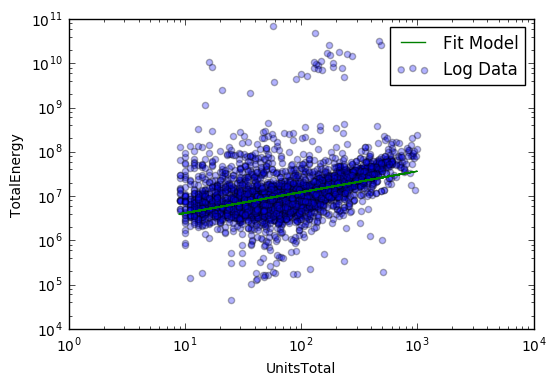

In [102]:
secDegree = smf.ols(formula = 'np.log10(TotalEnergy) ~ np.log10(np.power(UnitsTotal,2)) + np.log10(UnitsTotal)',
                    data = bblnrgdata_cut).fit()

ax = bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'TotalEnergy', kind = 'scatter', loglog = True, label = 'Log Data',
                        alpha = 0.3)
ax.plot(bblnrgdata_cut['UnitsTotal'], 10**secDegree.predict(), c = 'g', label = 'Fit Model')
ax.legend()

secDegree.summary()

## Figure 8: a 2-nd degree polynomial fit line of Units vs Energy

#### Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test. The formula is:
#### LR = -2 * (logLikelihood_Model1 - logLikelihoodModel2) where Model1 is the least complex (fewer parameters). Th logLikelihood can be extracted from the model summary when using statsmodels. Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if at alpha = 0.05 Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N{DOF} = parameters_Model2 - parameters_Model1 Also if you used statsmodels for the fit you can use the compare_lr_test() method of your fit and verify you got the right answer. Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))

In [105]:
print ("LR : ", -2 * (linmodel1.llf - (secDegree.llf)))
print ("LR from statsmodels:", secDegree.compare_lr_test(linmodel1))

LR :  -1.81898940355e-12
LR from statsmodels: (-1.8189894035458565e-12, nan, 0.0)


#### so these two models seem the same.